#Name: Mann Dsylva
#Roll no: 24MAI009

#Practical 8 : Variational Autoencoder

Epoch 1/20
Loss: 181.914306640625
Epoch 2/20
Loss: 172.988525390625
Epoch 3/20
Loss: 167.75706481933594
Epoch 4/20
Loss: 164.3065185546875
Epoch 5/20
Loss: 162.8129119873047
Epoch 6/20
Loss: 161.01800537109375
Epoch 7/20
Loss: 159.90660095214844
Epoch 8/20
Loss: 159.00697326660156
Epoch 9/20
Loss: 158.27330017089844
Epoch 10/20
Loss: 157.18226623535156
Epoch 11/20
Loss: 155.53697204589844
Epoch 12/20
Loss: 154.06996154785156
Epoch 13/20
Loss: 154.075927734375
Epoch 14/20
Loss: 154.18553161621094
Epoch 15/20
Loss: 153.10816955566406
Epoch 16/20
Loss: 152.5873260498047
Epoch 17/20
Loss: 151.85647583007812
Epoch 18/20
Loss: 151.90882873535156
Epoch 19/20
Loss: 150.2215118408203
Epoch 20/20
Loss: 150.9467010498047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━

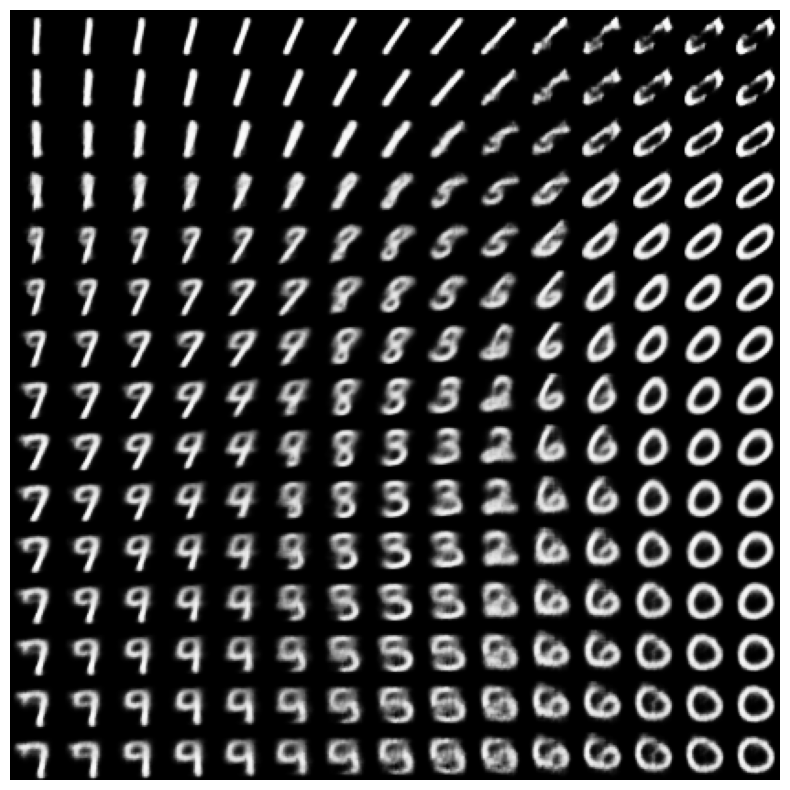

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and preprocess MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Define VAE model parameters
latent_dim = 2  # Dimension of the latent space

# Encoder network
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Custom Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

# Decoder network
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

# Models
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
decoder = Model(decoder_inputs, outputs, name="decoder")
vae_outputs = decoder(z)
vae = Model(inputs, vae_outputs, name="vae")

# Define the custom training loop
optimizer = tf.keras.optimizers.Adam()

# Loss functions
def compute_loss(x, x_decoded, z_mean, z_log_var):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(x, x_decoded)
    ) * 28 * 28
    # KL divergence
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Training step
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(x)
        x_decoded = decoder(z)
        loss = compute_loss(x, x_decoded, z_mean, z_log_var)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Train the VAE model
epochs = 20
batch_size = 128
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i + batch_size]
        loss = train_step(batch)
    print(f"Loss: {loss.numpy()}")

# Test the VAE by generating images from random points in the latent space
def plot_latent_space(decoder, n=15, digit_size=28):
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="Greys_r")
    plt.axis("off")
    plt.show()

plot_latent_space(decoder)